In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 5.1 MB/s eta 0:00:00


Comprimento total do MST entre os POIs selecionados: 61174.969428081655 metros


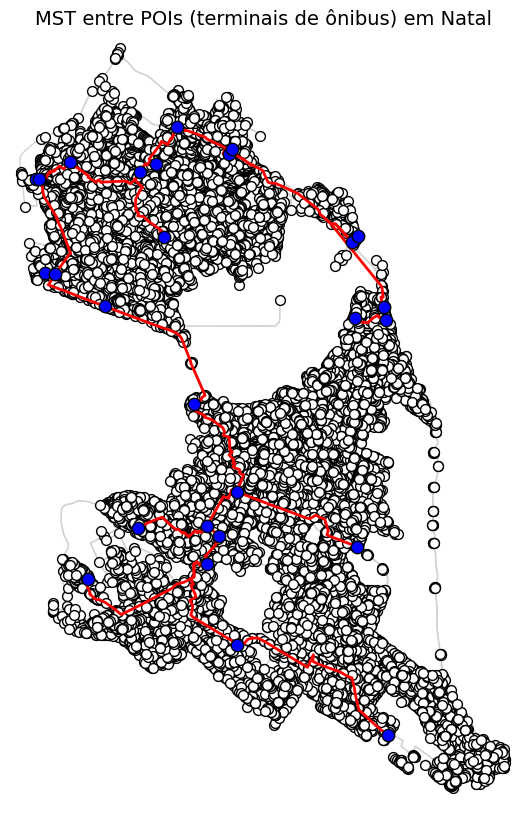

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

# ============================================
# 2. Obter POIs de interesse (terminais de ônibus como exemplo)
# ============================================
tags = {'amenity': 'bus_station'}  # Substitua conforme necessário
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
poi_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':  # Se for ponto
        poi_points.append((row.geometry.y, row.geometry.x))
    elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:  # Se for polígono
        poi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not poi_points:
    raise ValueError("Nenhum POI encontrado para a categoria especificada.")

# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [poi[0] for poi in poi_points]
longitudes = [poi[1] for poi in poi_points]
poi_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
poi_nodes = list(set(poi_nodes))  # Remover duplicados

if len(poi_nodes) < 2:
    raise ValueError("POIs insuficientes para criar uma MST (menos de 2 pontos).")

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(poi_nodes)):
    for j in range(i + 1, len(poi_nodes)):
        route = nx.shortest_path(G_undirected, poi_nodes[i], poi_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route) - 1):
            route_length += G_undirected[route[k]][route[k + 1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(poi_nodes[i], poi_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

# Criar uma lista de rotas MST para visualização
mst_routes = []
for u, v, d in mst_edges:
    mst_routes.append(nx.shortest_path(G_undirected, u, v, weight='length'))

# ============================================
# 6. Visualizar o MST
# ============================================
fig, ax = ox.plot_graph(
    G_undirected,
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='white',  # fundo branco
    figsize=(10, 10)
)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs em azul
poi_x = [G_undirected.nodes[n]['x'] for n in poi_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in poi_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (terminais de ônibus) em Natal", fontsize=14)
plt.show()
